## Prep

In [113]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [114]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-24 16:17:02.054486+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-24 16:17:08.336413+10:00 - Saved token with '2025-06-24 20:17:08+10:00' expiry...


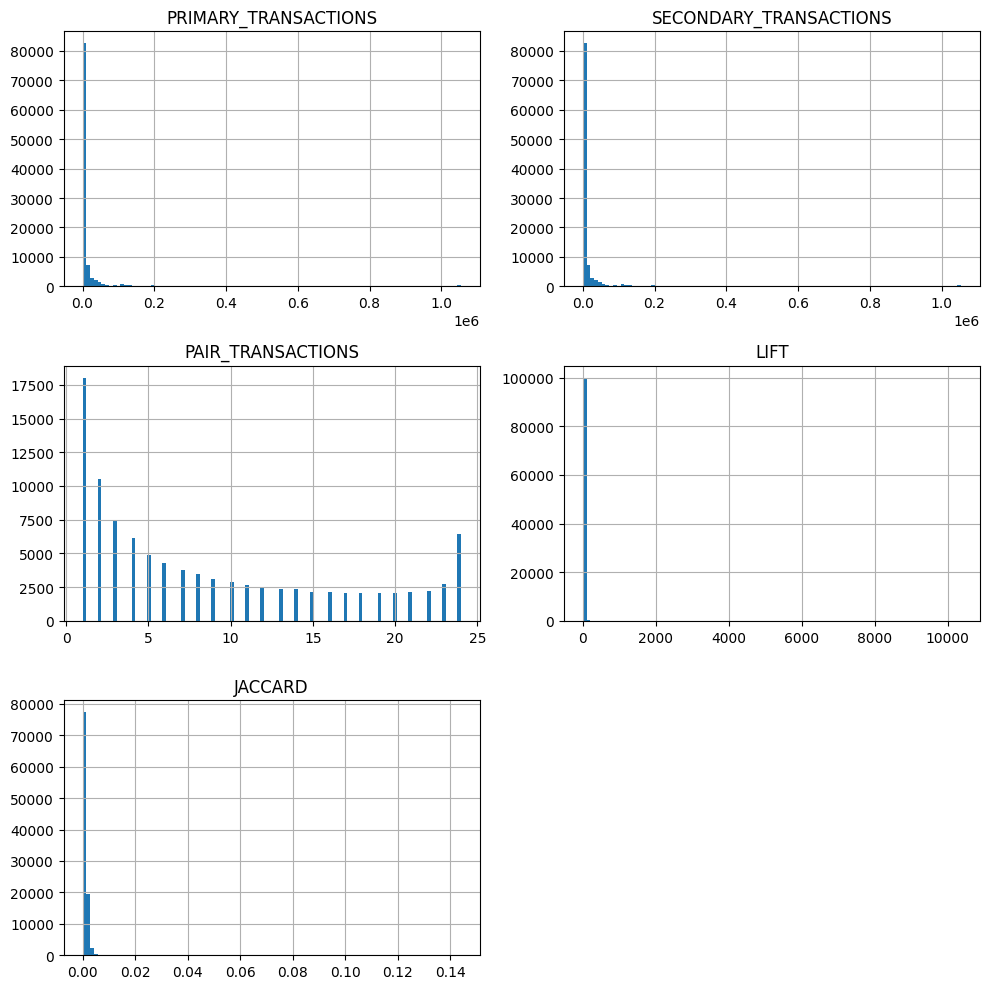

In [115]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

## Parameter Tuning

In [196]:
TRX_THRESHOLD = 10 # Min N frequent pairs
QUANTILE = 0.999 # Nth percentile of metric similarity
TOP_N = 5 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [197]:
filtered_df = df[(df['PRIMARY_ID'] != '400 GROWING MEDIA' ) & ( df['SECONDARY_ID']!='400 GROWING MEDIA')]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


In [198]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
69415,401 FLOORING ADHESIVE,401 TILES AND SHEETING,672,550,2024-07-01,2025-06-01,22,62.760714,0.018333
85073,401 TILES AND SHEETING,401 FLOORING ADHESIVE,551,672,2024-07-01,2025-06-01,22,62.646811,0.018318
36717,400 NZ COLD FOOD SWEET,400 NZ HOT DRINKS,100,181,2024-07-01,2025-06-01,22,1270.609392,0.084942
36822,400 NZ HOT DRINKS,400 NZ COLD FOOD SWEET,181,99,2024-07-01,2025-06-01,22,1285.620626,0.085271
69632,401 FLOORING TRIM,401 FLOORING ADHESIVE,460,672,2024-07-01,2025-06-01,20,68.218168,0.017986
69370,401 FLOORING ADHESIVE,401 FLOORING TRIM,672,460,2024-07-01,2025-06-01,20,68.218168,0.017986
60911,401 AUTO ELECTRICAL,400 AUTO ACCESSORIES,195,665,2024-07-01,2025-05-01,18,146.356969,0.021378
99937,HIRE SHOP OTHER SDT,HIRE SHOP CONSUMABLES SDT,75,578,2024-07-01,2025-06-01,18,415.030173,0.028346
99936,HIRE SHOP OTHER SDT,HIRE SHOP CHARGES SDT,75,68,2024-07-01,2025-06-01,18,3527.756471,0.144000
99837,HIRE SHOP CONSUMABLES SDT,HIRE SHOP OTHER SDT,593,74,2024-07-01,2025-06-01,18,432.497151,0.027735


In [199]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [200]:
fig.show()

In [208]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# display(labelled_df)

In [204]:
# Sum of PRIMARY_TRANSACTIONS by PRIMARY_ID and segment
grouped = labelled_df.groupby(['segment', 'PRIMARY_ID'])['PRIMARY_TRANSACTIONS'].sum().reset_index()

# Sum total per segment
segment_totals = grouped.groupby('segment')['PRIMARY_TRANSACTIONS'].sum().reset_index(name='segment_total')

# Merge back to get both individual and segment totals
merged = grouped.merge(segment_totals, on='segment')
merged

,segment,PRIMARY_ID,PRIMARY_TRANSACTIONS,segment_total
0,0,HIRE SHOP CHARGES SDT,138,1474
1,0,HIRE SHOP CONSUMABLES SDT,1186,1474
2,0,HIRE SHOP OTHER SDT,150,1474
3,1,400 NZ COLD FOOD SWEET,100,281
4,1,400 NZ HOT DRINKS,181,281
5,2,400 CLADDING,162,4020
6,2,400 FIBRECEMENT AND ACCESS,374,4020
7,2,400 FRAMING TIMBER,3060,4020
8,2,400 NON STRUCTURAL TIMBER,222,4020
9,2,400 STRUCTURAL OTHER,202,4020


## (NOT USED - 5 YEARS DATA, JUST 200 GARDENING)

**Segment 0 – Pest Control Execution Kit**
- 400 HOUSEHOLD PEST CONTROL
- 400 RODENT PEST CONTROL
- 400 FLYING PEST CONTROL
- 400 CRAWLING PEST CONTROL
- 400 ANIMAL CONTROL
- 400 GARDEN SPRAYER

Interpretation: Customers in this segment are maintaining plant health and site hygiene. Growing media here is likely paired with pesticides, traps, or sprays as part of broader pest-prevention cycles, particularly for outdoor or food-growing areas.

**Segment 1 –  Structural & Decorative Fit-Out**
- 400 ROSE
- 400 PLANTS OFF RANGE
- 400 CLIMBING PLANT
- 400 PALMS
- 400 GROUNDCOVER PLANT
- 400 ARTIFICIAL
- 400 OUTDOOR DECORATIVE
- 400 MOSQUITO CONTROL
- 400 ELECTRONIC INSECT CONTROL
- 400 VERTICAL GARDEN
- 400 TROPICAL
- 400 BORDERS HEDGING SCREENING

Interpretation: Growing media is purchased alongside aesthetic or landscape-related items. This suggests customers are designing or maintaining visually appealing gardens, possibly with tropical or decorative themes, supported by soil and growing inputs.

**Segment 2 – Natural Home Gardening**
- 400 TREE AND SHRUB
- 400 HOUSE PLANT
- 400 GARDEN DECOR OFF RANGE
- 400 OUTDOOR PLANTER
- 400 HERBS
- 400 PERENNIAL FLOWERING
- 400 GARDEN CARE OFF RANGE
- 400 SHADE PLANT
- 400 FRUIT AND CITRUS

Interpretation: This is the core gardening cluster. Customers are focused on home planting, combining growing media with pots, fruiting plants, herbs, and flowering varieties. Reflects active planting or re-potting activity for personal or decorative purposes.

**Segment 3 – Propagation Setup**
- 400 SUPPLIER LIT GARDEN CARE
- 400 PROPAGATION

Interpretation: A specialised niche of customers focused on propagation and plant-starting. Growing media here is used in seeding trays, cuttings, and early-stage care — possibly purchased by more advanced or volume-focused gardeners.

**Summary:** Growing media purchases group into four distinct intent-based baskets:
- Pest & Disease Control Routine. (Segment 0)
- Planting & Landscaping Projects (Segment 1 & 2)
- Propagation Setup for plant growth (Segment 3)